In [36]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict

### Data Generation

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95647/2401211233.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  points = np.random.multivariate_normal(mean, cov, n)


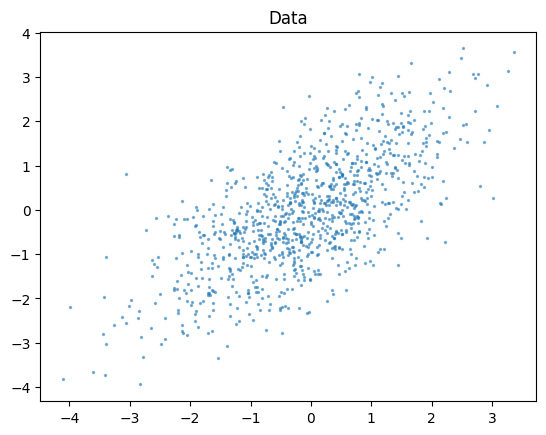

In [37]:
# main parameters
n = 1000
k = 5
num_nearest = 5
maxiter = 10000
temp = 10
alpha = 0.8

# Data parameters
cov = np.array([[1, 1.5], [1.5, 1]])
mean = np.array([0, 0])

# Generate the data and plot it
points = np.random.multivariate_normal(mean, cov, n)
plt.title("Data")
plt.scatter(points[:,0], points[:,1], s=2, alpha=0.5)
plt.show()

### Train Adjacency Matrix

In [38]:
def greedy_approach(k, D):
    # Get the number of nodes, square the distance matrix, and sum across the columns
    n = D.shape[0]
    node_values = np.sum(D, axis=0)
    D_copy = D.copy()

    # make the diagonal of the distance matrix infinite and make a visited array
    np.fill_diagonal(D_copy, np.inf)
    visited = np.zeros(n)

    # Initialize the matrix and loop through the number of edges 'k' we will be adding to each node
    matrix = np.zeros((n, n))
    for iteration in range(k):
        current_vals = node_values.copy()
        node_mask = (visited <= iteration)

        # For every edge iteration, choose the most isolated node and find its closest neighbor
        while np.sum(visited) < (iteration+1)*n:
            i = np.argmax(current_vals * node_mask)
            j = np.argmin(D_copy[:,i] / node_mask)

            # Mark the nodes as visited and update the matrix
            visited[i] += 1
            visited[j] += 1
            node_mask[i], node_mask[j] = False, False
            matrix[i, j], matrix[j, i] = 1, 1

            # subtract the distance between i and j from the node values for the next iteration
            node_values[i] -= D[i, j]
            node_values[j] -= D[i, j]

            # Make it so that the edges cannot be chosen again
            D_copy[i, j], D_copy[j, i] = np.inf, np.inf

    # Return the matrix
    return matrix


def find_near_solution(adj_matrix, D, nearest = 5):
    matrix = adj_matrix.copy()
    n = matrix.shape[0]
    # Choose a random column/node
    j1 = np.random.choice(n)

    # find a node that is connected to j1
    i_one_j1 = np.random.choice(np.where(matrix[:,j1]==1)[0])

    # Find the zero candidates and remove the diagonal element
    zero_candidates = np.where(matrix[:,j1]==0)[0]
    zero_candidates = zero_candidates[zero_candidates != j1]
    
    # Limit the number of candidates to the nearest nodes
    close_nots = np.argpartition(D[zero_candidates,j1], nearest)[:nearest]
    i_not_j1 = np.random.choice(zero_candidates[close_nots])
    
    # Alternative way to choose the node without a hyperparameter (Not as good though)
    # weights = np.log1p((1/D[zero_candidates,j1])**2)
    # weights = weights / np.sum(weights)
    # i_not_j1 = np.random.choice(zero_candidates, p=weights)

    # find a correct j2 which is not connected to i_one_j1
    fails = 0
    while True:
        j2 = np.random.choice(np.where(matrix[i_not_j1]==1)[0])
        fails += 1

        # If fails is too high, just return the matrix
        if fails % 100 == 0:
            return matrix
        
        # Check if the node is not connected to i_one_j1
        if (matrix[i_one_j1,j2]) == 0 and (j2 != j1) and (i_one_j1 != j2):
            break

    # swap the two nodes that are connected to j1
    matrix[i_one_j1,j1] = 0
    matrix[j1,i_one_j1] = 0
    matrix[i_not_j1,j1] = 1
    matrix[j1,i_not_j1] = 1    

    # # swap the two nodes that are connected to j2
    matrix[i_not_j1,j2] = 0
    matrix[j2,i_not_j1] = 0
    matrix[i_one_j1,j2] = 1
    matrix[j2,i_one_j1] = 1
        
    # Return the near solution
    return matrix


def annealing(adj_mat, D, num_nearest=5, maxiter = 100, temp = 1000, alpha = 0.99):
    # Initialize the loss list, the current adjacency matrix, and append the current loss
    loss_list = []
    current = adj_mat.copy()
    loss_current = np.sum((D**1) * current)
    loss_list.append(loss_current)
    accept_list = []

    # Loop through the maximum number of iterations
    for i in range(maxiter):
        T = max(temp*alpha**i,10e-20) + 1/(i+1)

        # copy and get the current candidate
        candidate = find_near_solution(current.copy(), D, nearest=num_nearest)

        # get the loss of the candidate and check if it is better than the current loss
        loss_candidate = np.sum((D**1) * candidate)
        if loss_candidate < loss_current:
            current = candidate
            loss_current = loss_candidate

        # Otherwise, accept the candidate with a certain probability
        else:
            prob = np.exp(np.max([-(loss_candidate - loss_current) / T,-50]))
            accept_list.append(prob)
            if np.random.rand() < prob:
                current = candidate
                loss_current = loss_candidate

        # Append the loss to the loss list
        loss_list.append(loss_current)

    # Return the adjacency matrix and the loss list
    return current, loss_list, accept_list


def get_adjacency_matrix(data, k, metric, num_nearest=5, maxiter=10000, temp=10, alpha=0.8, show_loss=False):
    # Get the distance matrix according to the matric and run the greedy approach and the annealing algorithm
    D = np.apply_along_axis(metric, 2, data[:,np.newaxis,:] - data[np.newaxis,:,:])
    matrix = greedy_approach(k, D)
    annealed, loss_list, accept_list = annealing(matrix, D, num_nearest=num_nearest, maxiter=maxiter, temp=temp, alpha=alpha)

    # Plot the loss list if required
    if show_loss:
        plt.title("Loss over iterations")
        plt.plot(loss_list)
        plt.show()
        
        # Print the loss and the improvement
        print("Greedy Approach {}".format(np.sum(matrix * D)))
        print("Annealed Solution {}".format(np.sum(annealed * D)))
        print("Annealed Improvement: {}%".format(np.round(100*(np.sum(matrix * D) - np.sum(annealed * D)) / np.sum(matrix * D),4)))

    # Return the adjacency matrix
    return matrix

In [39]:
tester = get_adjacency_matrix(points, k, np.linalg.norm, num_nearest=num_nearest, maxiter=maxiter, temp=temp, alpha=alpha, show_loss=False)

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95647/3960021799.py:20: RuntimeWarning: divide by zero encountered in divide
  j = np.argmin(D_copy[:,i] / node_mask)


### Construct Walk Matrix

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95647/1200423666.py:24: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  point = np.random.multivariate_normal(mean, cov, 1)
/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95647/1200423666.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Confidence')


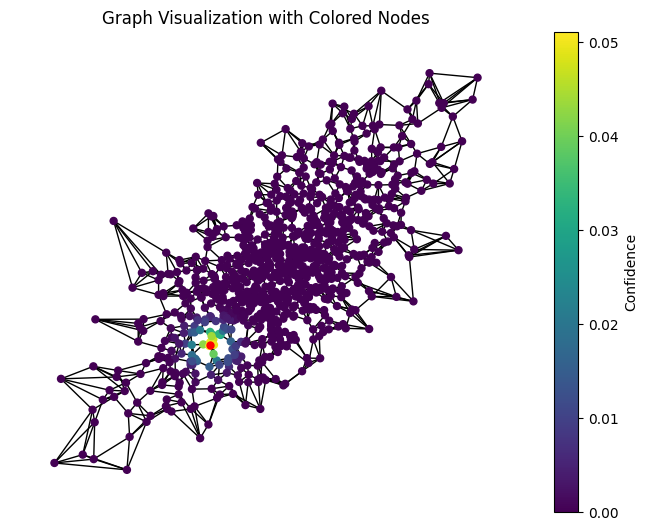

In [52]:
def get_transition_matrix(point, adj_matrix, data, metric, beta=1, reg = .05):
    # Check the shape of the data and the point
    if len(point.shape) == 1:
        point = point[np.newaxis,:]
    transition_matrices = []

    # Get the different distance arrays and gaussian weights
    dist_array = np.apply_along_axis(metric, 2, data[:,np.newaxis,:] - point[np.newaxis,:,:])
    std = np.std(dist_array)
    for i in range(dist_array.shape[1]):
        edge_weights = np.exp(-dist_array[:,i]**2 / (beta*std**2))
        n = data.shape[0]

        # Make and normalize the transition matrix
        transition = adj_matrix*edge_weights
        transition = (transition / np.sum(transition, axis=1, keepdims=True)) + reg/n
        transition /= np.sum(transition, axis=1, keepdims=True)
        transition_matrices.append(transition)

    # Return the transition matrix
    return transition_matrices

    
point = np.random.multivariate_normal(mean, cov, 1)
transition = get_transition_matrix(point, tester, points, np.linalg.norm, beta=.15, reg = 0)[0]

# Get the largest eigenvalue and eigenvector
eigenvalues, eigenvectors = np.linalg.eig(transition.T)
stationary = np.real(eigenvectors[:,np.argmax(np.real(eigenvalues))])
stationary /= np.sum(stationary)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(tester)

# Assign colors based on values
colors = plt.cm.viridis(stationary / max(stationary))  # Normalize values to [0, 1] for colormap

# Draw the graph
pos = {i: points[i] for i in range(n)}
nx.draw(G, pos, node_color=colors, cmap=plt.cm.viridis, node_size=25, font_color='white')

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(stationary), vmax=max(stationary)))
sm.set_array(stationary)
plt.colorbar(sm, label='Confidence')
plt.plot(point[0][0], point[0][1], 'ro', markersize=5)

plt.title('Graph Visualization with Colored Nodes')
plt.show()


In [41]:
I = np.eye(5)
array = np.arange(5)

I * array

array([[0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 2., 0., 0.],
       [0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 4.]])

In [42]:
class global_1:
    def __init__(self, k = 6, nearest = 5, maxiter = 1000, temp = 10, cool_rate = 0.8, std=.5, reg = .005):
        # Initialize the parameters
        self.k = k # Number of edges to add to each node (IMPORTANT HYPERPARAMETER)
        self.std = std  # Standard deviation of the gaussian, (IMPORTANT HYPERPARAMETER)
        self.reg = reg  # Regularization parameter for the transition matrix (IMPORTANT HYPERPARAMETER)
        self.nearest = nearest
        self.maxiter = maxiter
        self.temp = temp
        self.cool_rate = cool_rate
        

        # Initialize the variables to be used
        self.n = None
        self.d = None
        self.X = None
        self.y = None
        self.distances_matrix = None
        self.adj_matrix = None
        self.metric = None
        self.total_graph_distance = []


    ########################### Construct Adjacency Matrix ###########################
    def greedy_approach(self):
        """An initial greedy approach to the graph construction
        Output:
            matrix (n,n) ndarray - The greedy adjacency matrix of the graph"""
        # Get the number of nodes, square the distance matrix, and sum across the columns
        node_values = np.sum(self.distances_matrix, axis=0)
        d_copy = self.distances_matrix.copy()

        # make the diagonal of the distance matrix infinite and make a visited array
        np.fill_diagonal(d_copy, np.inf)
        visited = np.zeros(self.n)

        # Initialize the matrix and loop through the number of edges 'k' we will be adding to each node
        matrix = np.zeros((self.n, self.n))
        for iteration in range(self.k):
            current_vals = node_values.copy()
            node_mask = (visited <= iteration)

            # For every edge iteration, choose the most isolated node and find its closest neighbor
            while np.sum(visited) < (iteration+1)*self.n:
                i = np.argmax(current_vals * node_mask)
                j = np.argmin(d_copy[:,i] / node_mask)

                # Mark the nodes as visited and update the matrix
                visited[i] += 1
                visited[j] += 1
                node_mask[i], node_mask[j] = False, False
                matrix[i, j], matrix[j, i] = 1, 1

                # subtract the distance between i and j from the node values for the next iteration
                node_values[i] -= self.distances_matrix[i, j]
                node_values[j] -= self.distances_matrix[i, j]

                # Make it so that the edges cannot be chosen again
                d_copy[i, j], d_copy[j, i] = np.inf, np.inf

        # Return the matrix
        self.adj_matrix = matrix
        self.total_graph_distance = []
        return matrix

    def find_near_solution(self, previous_solution):
        """Find near solution to the previous solution to be used in annealing
        Input:
            previous_solution (n,n) ndarray - The previous adjacency matrix
        Output:
            near_matrix (n,n) ndarray - The near adjacency matrix"""
        near_matrix = previous_solution.copy()
        # Choose a random column/node
        j1 = np.random.choice(self.n)

        # find a node that is connected to j1
        i_one_j1 = np.random.choice(np.where(near_matrix[:,j1]==1)[0])

        # Find the zero candidates and remove the diagonal element
        zero_candidates = np.where(near_matrix[:,j1]==0)[0]
        zero_candidates = zero_candidates[zero_candidates != j1]
        
        # Limit the number of candidates to the nearest nodes
        close_nots = np.argpartition(self.distances_matrix[zero_candidates,j1], self.nearest)[:self.nearest]
        i_not_j1 = np.random.choice(zero_candidates[close_nots])
        
        # Alternative way to choose the node without a hyperparameter (Not as good though)
        # weights = np.log1p((1/self.distances_matrix[zero_candidates,j1])**2)
        # weights = weights / np.sum(weights)
        # i_not_j1 = np.random.choice(zero_candidates, p=weights)

        # find a correct j2 which is not connected to i_one_j1
        fails = 0
        while True:
            j2 = np.random.choice(np.where(near_matrix[i_not_j1]==1)[0])
            fails += 1

            # If fails is too high, just return the matrix
            if fails % 100 == 0:
                return near_matrix
            
            # Check if the node is not connected to i_one_j1
            if (near_matrix[i_one_j1,j2]) == 0 and (j2 != j1) and (i_one_j1 != j2):
                break

        # swap the two nodes that are connected to j1
        near_matrix[i_one_j1,j1] = 0
        near_matrix[j1,i_one_j1] = 0
        near_matrix[i_not_j1,j1] = 1
        near_matrix[j1,i_not_j1] = 1    

        # # swap the two nodes that are connected to j2
        near_matrix[i_not_j1,j2] = 0
        near_matrix[j2,i_not_j1] = 0
        near_matrix[i_one_j1,j2] = 1
        near_matrix[j2,i_one_j1] = 1
            
        # Return the near solution
        return near_matrix
    
    def annealing(self):
        """Do simulated annealing to find the best adjacency matrix
        Output:
            current (n,n) ndarray - The best adjacency matrix found"""
        # Raise an error if the greedy approach has not been run
        if self.adj_matrix is None:
            raise ValueError("Please run the greedy approach first")

        # Initialize the loss list, the current adjacency matrix, and append the current loss
        current = self.adj_matrix.copy()
        loss_current = np.sum((self.distances_matrix**1) * current)
        self.total_graph_distance.append(loss_current)

        # Loop through the maximum number of iterations
        for i in range(self.maxiter):
            T = max(self.temp*self.cool_rate**i,10e-20) + 1/(i+1)

            # copy and get the current candidate
            candidate = self.find_near_solution(current.copy())

            # get the loss of the candidate and check if it is better than the current loss
            loss_candidate = np.sum((self.distances_matrix**1) * candidate)
            if loss_candidate < loss_current:
                current = candidate
                loss_current = loss_candidate

            # Otherwise, accept the candidate with a certain probability
            else:
                prob = np.exp(np.max([-(loss_candidate - loss_current) / T,-50]))
                if np.random.rand() < prob:
                    current = candidate
                    loss_current = loss_candidate

            # Append the loss to the loss list
            self.total_graph_distance.append(loss_current)

        # Return the adjacency matrix and the loss list
        self.adj_matrix = current
        return current
    
    def get_distance_matrix(self, data, metric):
        """Get the distance matrix of the data
        Input:
            data (n,d) ndarray - The data to get the distance matrix of
            metric function - The metric to use to get the distance matrix
        Output:
            distances_matrix (n,n) ndarray - The distance matrix of the data"""
        # Get the distance matrix according to the matric and run the greedy approach and the annealing algorithm
        self.distances_matrix = np.apply_along_axis(metric, 2, data[:,np.newaxis,:] - data[np.newaxis,:,:])
    

    ################################# Training #################################
    def fit(self, X, y, fit_metric = False, show_loss = False):
        """Fit the model to the data
        Input:
            X (n,d) ndarray - The data to fit the model to
            y (n,) ndarray - The labels of the data
            fit_metric bool - Whether to fit a metric function to the data or not
        Output:
            self - The fitted model"""
        # If we are to fit a metric, do so
        if fit_metric:
            self.get_metric(X, y)

        # Otherwise, set the metric to the default
        else:
            self.metric = np.linalg.norm

        # Get the distance matrix and other parameters
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.X = X
        self.y = y
        self.get_distance_matrix(X, self.metric)

        # Run the greedy approach and the annealing algorithm
        self.greedy_approach()
        greedy_matrix = self.adj_matrix.copy()
        self.annealing()

        # Plot the loss list if required
        if show_loss:
            self.show_total_distance(greedy_matrix, self.adj_matrix)

        # Return the model
        return self
    
    def get_metric(self, X, y):
        """Train a metric function to be used in the distance matrix
        Input: 
            X (n,d) ndarray - The data to train the metric on
            y (n,) ndarray - The labels of the data"""
        ###### FIX ME ##########
        self.metric = np.linalg.norm
        pass


    ################################# Prediction #################################
    def label_from_stationary(self, stationary, show_probabilities = False):
        """Get the label from the stationary distribution
        Input:
            stationary (n,) ndarray - The stationary distribution of the data
        Output:
            labels (n,) ndarray - The predicted labels of the data"""
         # Check if the sum of the stationary distribution is approximately 1
        if not np.isclose(np.sum(stationary), 1):
            raise ValueError("The weights do not sum to 1.")
        
        # Initialize a dictionary to hold the summed weights for each class
        class_weight_sums = defaultdict(float)
        
        # Sum the weights for each class
        for weight, label in zip(stationary, self.y):
            class_weight_sums[label] += weight
        
        # Convert to a regular dictionary for output
        class_probabilities = dict(class_weight_sums)
        if show_probabilities:
            return class_probabilities
        
        # Otherwise, return the class with the highest weight
        else:
            return max(class_probabilities, key=class_probabilities.get)
    
    def predict(self, points):
        # Check the shape of the data and the point
        if len(points.shape) == 1:
            points = points[np.newaxis,:]
        predictions = []

        # Get the different distance arrays and gaussian weights
        dist_array = np.apply_along_axis(self.metric, 2, self.X[:,np.newaxis,:] - point[np.newaxis,:,:])
        for i in range(dist_array.shape[1]):
            edge_weights = np.exp(-dist_array[:,i]**2 / self.std)

            # Make and normalize the transition matrix
            transition = self.adj_matrix*edge_weights
            transition = (transition / np.sum(transition, axis=1, keepdims=True)) + self.reg/self.n
            transition /= np.sum(transition, axis=1, keepdims=True)

            # Get the stationary distribution
            eigenvalues, eigenvectors = np.linalg.eig(transition.T)
            stationary = np.real(eigenvectors[:,np.argmax(np.real(eigenvalues))])
            stationary /= np.sum(stationary)
            predictions.append(self.label_from_stationary(stationary))

        # Return the transition matrix
        return predictions
    


    ################################## Analysis ##################################
    def show_total_distance(self, start_matrix=None, end_matrix=None):
        """Show the total graph distance between two losses
        Input:
            start_loss (float) - The starting loss
            end_loss (float) - The ending loss
        Output:
            total_distance float - The total graph distance between the two losses"""
        # Get the total graph distance
        plt.title("Loss over iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Total Graph Distance")
        plt.plot(self.total_graph_distance)
        plt.show()
        
        # Print the loss and the improvement
        if start_matrix is not None and end_matrix is not None:
            greedy_distance = np.sum(start_matrix * self.distances_matrix)
            annealed_distance = np.sum(end_matrix * self.distances_matrix)
            print("Greedy Solution: {}".format(greedy_distance))
            print("Annealed Solution: {}".format(annealed_distance))
            print("Percent Decrease: {}%".format(np.round(100*(greedy_distance - annealed_distance) / greedy_distance,4)))